# Poisson Regression - Newton Raphson
#### by Andrew Rothman

Here we will explore Poisson Regression where we will: <br>
* Specify the statistical model and it's functional form
* Using the Iris dataset as a motivating example, we will recover estimates of the parameters of the model we specified using the iterative numerical algorithm Newton Raphson.

## 1) Model Specification
### Variables & Dimensions
Let us begin by specifying our variable relations and matrix dimensions:

$\begin{align}
Y
\end{align}$ ~ n iid Poisson RVs

$$
\begin{align}
\hat{Y} = A &= \sigma(Z) = e^{Z} \\
Z = X \hat{\beta} \\
\end{align}
$$

$\begin{aligned}
n=
\end{aligned}$ number of observations

$\begin{aligned}
p=
\end{aligned}$ number of parameters

Note, that in this formulation we are imbedding the intercept term into the Design and Parameter matrices

$$
\begin{align}
Y, A, Z &: n\times 1 \\
X &: n\times (p+1) \\
\hat{\beta} &: (p+1)\times 1 \\
\stackrel{\rightarrow}{1} &: n\times 1 \\
\end{align}
$$

### Cost Function (Negative Log Likelihood)
$$
\begin{align}
\mathcal{L}(A|Y) &= \prod_{i=1}^n \frac{A^{Y}e^{-A}}{Y!}    \\
-\ln (\mathcal{L}(A|Y)) = J &= \sum_{i=1}^n -Y\ln(A) + A + \ln(Y!) \\
J &= \sum_{i=1}^n -YX\hat{\beta} + A + \ln(Y!) \\
\end{align}
$$

in vectorized form, this reduces to:
$$
\begin{align}
J &= -Y^{T}X\hat{\beta} + (A+\ln(Y!))^{T}\stackrel{\rightarrow}{1}
\end{align}
$$

Note that:
$$
\begin{align}
J &= -Y^{T}X\hat{\beta} + (e^{X\hat{\beta}} + \ln(Y!))^{T}\stackrel{\rightarrow}{1} \\
\frac{\partial J}{\partial \hat{\beta}} &= -Y^{T}X + (e^{X\hat{\beta}})^{T}X   \\
\frac{\partial J}{\partial \hat{\beta}} &= -Y^{T}X + A^{T}X   \\
\frac{\partial J}{\partial \hat{\beta}} &= X^{T}(A-Y)   \\
\frac{\partial^{2} J}{\partial^{2} \hat{\beta}} &= (e^{X\hat{\beta}})^{T}\stackrel{\rightarrow}{1}*X^{T}X   \\
\end{align}
$$

### Newton Raphson Algorithm

$$
\begin{align}
\hat{\beta}_{i+1} = \hat{\beta}_i - (\frac{\partial^{2} J}{\partial^{2} \hat{\beta}_i})^{-1}\frac{\partial J}{\partial \hat{\beta}_i}
\end{align}
$$

## 2) Motivating Example with the "Iris" Dataset
We will show the above closed form solution in action with a motivating example. We will use the Iris Dataset to do so by:
* Using "Sepal Length" as our outcome of interest, with all remaining variables as covariates in the regression model
 * The variable "Sepal Length" has been reparameterized to a [0,1] variable with 
   * "Sepal Length" < 5.1 set to "0"
   * 5.1 <= "Sepal Length" < 5.8 set to "1"
   * 5.8 <= "Sepal Length" < 6.4 set to "2"
   * "Sepal Length" >= 6.4 set to "3"
 * Note, the variable "Species" is reparameterized as "one-hot" coding, with the category "virginica" set as the reference category

In [1]:
######################
## import libraries ##
######################
from scipy.misc import factorial
import numpy as np
import pandas as pd
from sklearn import datasets
import statsmodels.formula.api as sm
from statsmodels.genmod.families import Poisson
from numpy.linalg import inv
import matplotlib.pyplot as plt 

In [2]:
###################################
## import and clean iris dataset ##
###################################
iris = datasets.load_iris()
LR_df = pd.DataFrame()
LR_df['S_Length'] = iris['data'][:,0]
LR_df['Intercept']=np.full(iris['data'].shape[0], 1)
LR_df['S_Width'] = iris['data'][:,1]
LR_df['P_Length'] = iris['data'][:,2]
LR_df['P_Width'] = iris['data'][:,3]
LR_df['Species'] = iris['target']
LR_df['Species'] = LR_df['Species'].apply(str)
LR_df.loc[LR_df['Species']==str(0), "Species"] = str(iris['target_names'][0])
LR_df.loc[LR_df['Species']==str(1), "Species"] = str(iris['target_names'][1])
LR_df.loc[LR_df['Species']==str(2), "Species"] = str(iris['target_names'][2])
LR_df['Species_setosa']=0
LR_df.loc[LR_df['Species']=='setosa', 'Species_setosa']=1
LR_df['Species_versicolor']=0
LR_df.loc[LR_df['Species']=='versicolor', 'Species_versicolor']=1
LR_df.loc[LR_df['S_Length']<5.1, 'S_Length'] = 0
LR_df.loc[(LR_df['S_Length']>=5.1) & (LR_df['S_Length']<5.8), 'S_Length'] = 1
LR_df.loc[(LR_df['S_Length']>=5.8) & (LR_df['S_Length']<6.4), 'S_Length'] = 2
LR_df.loc[LR_df['S_Length']>=6.4, 'S_Length'] = 3
LR_df = LR_df.drop('Species', axis=1)
LR_df.describe()

,S_Length,Intercept,S_Width,P_Length,P_Width,Species_setosa,Species_versicolor
count,150.00000,150.0,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.58000,1.0,3.054000,3.758667,1.198667,0.333333,0.333333
std,1.11289,0.0,0.433594,1.764420,0.763161,0.472984,0.472984
min,0.00000,1.0,2.000000,1.000000,0.100000,0.000000,0.000000
25%,1.00000,1.0,2.800000,1.600000,0.300000,0.000000,0.000000
50%,2.00000,1.0,3.000000,4.350000,1.300000,0.000000,0.000000
75%,3.00000,1.0,3.300000,5.100000,1.800000,1.000000,1.000000
max,3.00000,1.0,4.400000,6.900000,2.500000,1.000000,1.000000


In [3]:
#######################################
## creat arrays for Gradient Descent ##
#######################################
Y = np.array(LR_df['S_Length']).reshape((len(LR_df['S_Length']), 1))
X = np.array(LR_df[['Intercept', 'S_Width', 'P_Length', 'P_Width', 'Species_setosa', 'Species_versicolor']])

## 3) Compute Solution

In [4]:
#################################
## initialize parameter matrix ##
#################################
k = X.shape[1]
np.random.seed(10815657)
nudge=0.1
Beta = np.random.uniform(low=-1*nudge, high=1*nudge, size=k).reshape(k, 1)
Z = np.dot(X, Beta)
A = np.exp(Z)
ones_vector = np.full(Y.shape[0], 1).reshape(Y.shape[0], 1)

In [5]:
############################
## Newton Raphson Descent ##
############################
m = 5000
J = pd.DataFrame()
J['iterative_step'] = range(0,m+1)
J['cost'] = np.full(m+1, None)
J.loc[0, 'cost'] = np.asscalar(-np.dot(Y.T, np.dot(X, Beta)) + np.dot((A+factorial(Y)).T, ones_vector))                        

for i in range(1, m+1):    
    J_partial_Beta = np.dot(X.T, (A-Y))
    J_2partial_Beta2 = np.dot(A.T, ones_vector)*np.dot(X.T, X)
        
    Beta = Beta - np.dot(inv(J_2partial_Beta2), J_partial_Beta)
    Z = np.dot(X, Beta)
    A = np.exp(Z)
    J.loc[i, 'cost'] = np.asscalar(-np.dot(Y.T, np.dot(X, Beta)) + np.dot((A+factorial(Y)).T, ones_vector))   
    del J_partial_Beta      

C:\Users\Andrew\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.
  
C:\Users\Andrew\Anaconda3\envs\py35\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `factorial` is deprecated!
Importing `factorial` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.factorial` instead.


array([[-2.38648466],
       [ 0.56337825],
       [ 0.3038413 ],
       [-0.04229405],
       [-0.77570476],
       [ 0.10596279]])

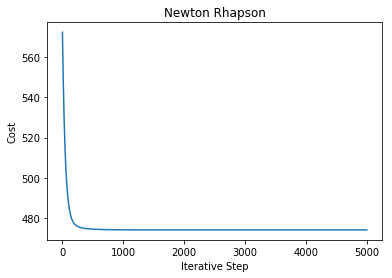

In [6]:
plt.plot(J['iterative_step'], J['cost'])
plt.title('Newton Rhapson') 
plt.xlabel('Iterative Step') 
plt.ylabel('Cost') 
Beta

In [7]:
print(Beta)

[[-2.38648466]
 [ 0.56337825]
 [ 0.3038413 ]
 [-0.04229405]
 [-0.77570476]
 [ 0.10596279]]


Let's compare this solution to that provided by the Logistic model provided in the "statsmodels" package

In [8]:
## built in package
results = sm.glm(formula="S_Length ~ S_Width + P_Length + P_Width + Species_setosa + Species_versicolor", data=LR_df, family=Poisson()).fit()
print(results.params)

Intercept            -2.386490
S_Width               0.563382
P_Length              0.303841
P_Width              -0.042296
Species_setosa       -0.775741
Species_versicolor    0.105962
dtype: float64
